## Georeference fracture trace maps

This notebook was designed to georefence a shapefile consisting line segments only using a control point file with three dimensional coordinates. 

This notebook requires the Python modules numpy, scipy, pandas, geopandas, shapely and sympy.

Elco Luijendijk, Oct.-Dec. 2020. <elco.luijendijk@posteo.net>

## Import some Python modules

In [128]:
import os
import itertools
import numpy as np
import pandas as pd
import geopandas as gp
import matplotlib.pyplot as pl
from mpl_toolkits.mplot3d import Axes3D
import scipy.optimize

import shapely
import sympy

## Variables for georeferencing

Update the variables ``shpfile``, ``control_pt_file`` and optionally ``plane_pt_file`` to your own shapefiles of the fracture network, ground control points, and points that define a plane, respectively.

In [129]:
# shapefile to be projected
shpfile = 'data/fractures.shp'

# shapefile with control points, ie points for which the coordinates are known
control_pt_file = 'data/control_pts.shp'

# columns in the control point file that designate real coordinates
cp_x_col = 'X'
cp_y_col = 'Y'
cp_z_col = 'ELEVATION'

# polynomial order for the transform function.
# use 1 or 2. 2nd order gives much better results in most cases, but needs more control pts.
order = 2

# absolute and relative tolerance of optimization algorithm to find the georeference transofrmation
# see https://docs.scipy.org/doc/scipy/reference/generated/scipy.optimize.fmin.html
# adjust these values if the georeferencing error is too high
xtol = 1e-12
ftol = 1e-12

# this is to try out if guessingg the initial best parameters improves the optimization of the 
# transform parameters. Seems to have no effect, so best leave on 'horizontal'
approximate_orientation = 'horizontal'

# guess the orientation of the outcrop as horizontal, vertical or inclined based on the control 
# point coords and adjust the inital guess of the transform parameters accordingly
# seems to have a minimal effect on the coorindate transform. best left at False
guess_orientation = False

# normalize coordinates
# this may help for datasets where the optimization algorithm cannot find a good transform
normalize_coords = False

## Optional parameters for projecting the 3D georefenced shapefile/lines onto a 2D plane

In [130]:
# Switch to turn projection to a plane on or off
project_shapefile = True

# use projection points from file or use min, max coords
get_plane_pts_from_file = False

# shapefile with three points that define a plane
# if the file contains more than three pts then the first three are used only
#plane_pt_file = 'data/L49_2_G_TM_plane_coords_GK3.shp'
plane_pt_file = 'data_Katie/L53_3_TM_plane_coords.shp'

# columns in the plane point file that designate real coordinates
pp_x_col = 'X'
pp_y_col = 'Y'
pp_z_col = 'Z'

# the index of the origin point for the two lines. 
# Change this if the notebook picks the wrong point as the origin for the two lines
# Note, Python starts counting at 0, so to use the first point in the shapefile as origin, leave this at 0
pp_origin_id = 0

# automatically sort the plane pts so that the origin is at the min x,y coordinate
# note, if selected this overrides the origin selected by pp_origin_id
sort_plane_pts = False

# if not using the file (get_plane_pts_from_file = False), use the min and max x, y and z coords to define a plane
# one does in this case need to define a orientation of the plane, choose 'vertical' or 'horizontal'
# in the first case the points are projected to a three pts, with the first two (xmin, ymin, zmin), (xmax, ymax, zmin) 
# and the last point directly above tthe first (xmin, ymin, zmax)
# in case of horizontal the three points are (xmin, ymin, zmin), (xmax, ymin, zmax), (xmin, ymax, zmin)
# the plane is then constructed using the two vectors (p1, p2) and (p1, p3)
plane_orientation = 'vertical'

# leave this variable at None to let the notebook set the minimum x, y and z coordinates as the origin of the plane
# otherwise use a nested list of numpy min and max functions to define x, y and z coordinates of the three plane points 
# this should contain three lists, the first for the x coordinates, the 2nd for the y coordinate, the 3rd for the z coordinates
# example plane_pt_functions = [[np.min, np.max, np.min], [np.min, np.max, np.min], [np.min, np.min, np.max]] 
# defines the three points as xcoords: min, max, min, ycoords: min, max, min, zcoords: min, min, max
plane_pt_functions = None
#plane_pt_functions = [[np.min, np.max, np.min],
#                      [np.min, np.max, np.min],
#                      [np.min, np.min, np.max]]

## Read control point file

In [131]:
cp = gp.read_file(control_pt_file)
cp

,ID,X,Y,ELEVATION,geometry
0,0,5742957.030,3588783.368,486.790,POINT (2026.601 -2236.399)
1,1,5742950.239,3588784.310,489.173,POINT (3745.403 -1620.575)
2,2,5742961.948,3588784.179,491.459,POINT (594.475 -959.583)
3,3,5742955.311,3588784.789,491.424,POINT (2465.584 -1001.695)
4,4,5742960.122,3588785.829,492.735,POINT (1303.852 -612.002)
5,6,5742960.575,3588783.942,490.463,POINT (1009.730 -1275.061)
6,7,5742960.680,3588783.291,488.866,POINT (976.612 -1760.686)
7,8,5742951.207,3588783.492,486.486,POINT (3453.906 -2291.213)
8,9,5742949.507,3588783.590,486.769,POINT (3872.096 -2206.428)
9,10,5742948.939,3588783.700,487.299,POINT (4038.409 -2085.556)


## Check the control point file

In [132]:
if np.any(cp.geometry.isnull()) == True:
    print('warning, somehow there is an empty point in your control point file.')
    print('please check the control pt file in qgis or arcgis')
    print('dropping all points without attributes or geometry and continuing')
    cp = cp.dropna(subset=['geometry'])

In [133]:
src = np.array([g.coords[:][0] for g in cp.geometry])
dst = np.array(list(zip(cp[cp_x_col], cp[cp_y_col], cp[cp_z_col])))

print('source coords extracted from control pt file:\n', src)
print('to be projected to:\n', dst)

source coords extracted from control pt file:
 [[ 2026.600641   -2236.39859409]
 [ 3745.40348893 -1620.57498587]
 [  594.47528058  -959.58308778]
 [ 2465.58406617 -1001.69516552]
 [ 1303.85225545  -612.00243682]
 [ 1009.72993149 -1275.06126473]
 [  976.61179963 -1760.68632727]
 [ 3453.90587901 -2291.21328058]
 [ 3872.09594357 -2206.42834611]
 [ 4038.40923014 -2085.55647722]
 [ 2283.28414554 -1918.77514907]
 [ 1908.17219302 -1221.13968454]
 [ 2072.40074422 -1006.28871815]
 [ 3274.12119293 -1690.92523543]
 [ 2982.34575363 -1338.21298869]
 [ 3052.41189315 -2448.84171029]
 [ 2837.32997651 -2098.54186916]
 [  796.81502251 -1801.28175071]]
to be projected to:
 [[5.74295703e+06 3.58878337e+06 4.86790000e+02]
 [5.74295024e+06 3.58878431e+06 4.89173000e+02]
 [5.74296195e+06 3.58878418e+06 4.91459000e+02]
 [5.74295531e+06 3.58878479e+06 4.91424000e+02]
 [5.74296012e+06 3.58878583e+06 4.92735000e+02]
 [5.74296058e+06 3.58878394e+06 4.90463000e+02]
 [5.74296068e+06 3.58878329e+06 4.88866000e+02]
 

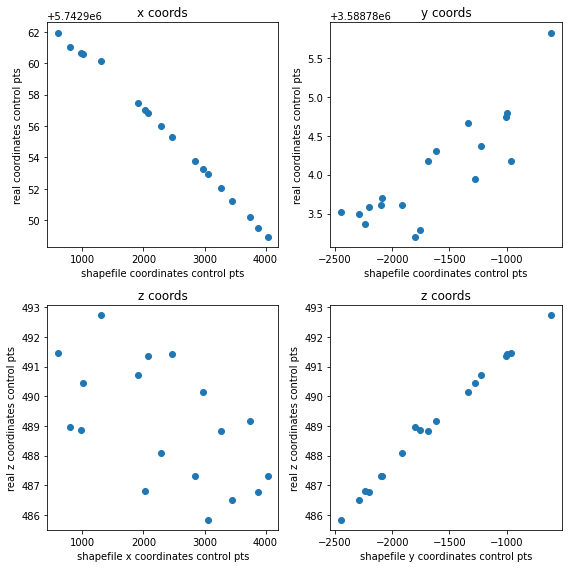

In [134]:
fig, axs = pl.subplots(2, 2, figsize=(8, 8))
axs = axs.ravel()
axs[0].scatter(src[:, 0], dst[:, 0])
axs[1].scatter(src[:, 1], dst[:, 1])
axs[2].scatter(src[:, 0], dst[:, 2])
axs[3].scatter(src[:, 1], dst[:, 2])

for ax in axs[:2]:
    ax.set_xlabel('shapefile coordinates control pts')
    ax.set_ylabel('real coordinates control pts')

axs[2].set_xlabel('shapefile x coordinates control pts')
axs[2].set_ylabel('real z coordinates control pts')
axs[3].set_xlabel('shapefile y coordinates control pts')
axs[3].set_ylabel('real z coordinates control pts')
    
axs[0].set_title('x coords')
axs[1].set_title('y coords')
axs[2].set_title('z coords')
axs[3].set_title('z coords')

fig.tight_layout()

## Some functions to transform coordinates

In [135]:
def transform(params, x, y, order):
    
    if order == 1:
        ax, bx, cx, ay, by, cy, az, bz, cz = params
        x_transformed = ax * x + bx * y + cx
        y_transformed = ay * x + by * y + cy
        z_transformed = az * x + bz * y + cz 
        
    elif order == 2:
        ax, bx, cx, dx, ex, ay, by, cy, dy, ey, az, bz, cz, dz, ez = params
        x_transformed = ax * x + bx * x**2 + cx * y + dx * y**2 + ex
        y_transformed = ay * x + by * x**2 + cy * y + dy * y**2 + ey
        z_transformed = az * x + bz * x**2 + cz * y + dz * y**2 + ez
        
    return x_transformed, y_transformed, z_transformed


def get_transform_error(params, src, dst, order):
    
    x_src = src[:, 0]
    y_src = src[:, 1]

    x_dst = dst[:, 0]
    y_dst = dst[:, 1]
    z_dst = dst[:, 2]

    # optional, transform coords by substracting lower bounds
    # this may make optimization easier
    norm_dst_coords = False
    if norm_dst_coords is True:
        
        x_dst_i = dst[:, 0]
        y_dst_i = dst[:, 1]
        z_dst_i = dst[:, 2]

        x0 = x_dst_i.min()
        y0 = y_dst_i.min()
        z0 = z_dst_i.min()

        x_dst = x_dst_i - x0
        y_dst = x_dst_i - y0
        z_dst = x_dst_i - z0
    
    # transform the source coordinates
    xt, yt, zt = transform(params, x_src, y_src, order)
    
    if norm_dst_coords is True:
        xt += x0
        yt += y0
        zt += z0
    
    # check how far off the coordinates are from their real coords
    xd = x_dst - xt
    yd = y_dst - yt
    zd = z_dst - zt
    err = np.sqrt(xd**2 + yd**2 + zd**2)
    
    # calculate the RMSE and return this
    rmse = np.sqrt(np.mean((err)**2))
    me = np.mean(err)
    
    #print(rmse)
    
    # use the sum of the rmse and the mean error as the misfit measure:
    total_err = rmse + me
    
    return total_err


def transform_func(params, src, order):
    
    x_src = src[:, 0]
    y_src = src[:, 1]
    
    xt, yt, zt = transform(params, x_src, y_src, order)
    
    return np.vstack([xt, yt, zt]).T

## Check input data

In [136]:
x_span_src = src[:, 0].max() - src[:, 0].min()
y_span_src = src[:, 1].max() - src[:, 1].min()

span_over_coord_vals_x = np.abs(x_span_src / src[:, 0].min())
span_over_coord_vals_y = np.abs(y_span_src / src[:, 1].min())

if span_over_coord_vals_x < 1e-3:
    print('-' * 30)
    print('warning:\nthe difference between the source x coordinates in the control pt file is %0.2e times smaller than the x value itself' % (1./span_over_coord_vals_x))
    print('the optimization algorithm may not find a coordinate transform.')
    print('Please adjust the control point and fracture shapefiles')
    print('And/or set the parameter normalize_coords = True')
    print('-' * 30)
    
if span_over_coord_vals_y < 1e-3:
    print('-' * 30)
    print('warning:\nthe difference between the source y coordinates in the control pt file is %0.2e times smaller than the y value itself' % (1./span_over_coord_vals_y))
    print('the optimization algorithm may not find a coordinate transform.')
    print('Please adjust the control point and fracture shapefiles')
    print('And/or set the parameter normalize_coords = True')
    print('-' * 30)

## Run optimization algorithm to find transform for control points

In [137]:
if normalize_coords is True:
    
    print('normalizing coordinates')
    
    # normalize dst coords
    dst_norms = (dst[:, 0].min(), dst[:, 1].min(), dst[:, 2].min())
    
    dst_norm = dst.copy()
    dst_norm[:, 0] -= dst_norms[0]
    dst_norm[:, 1] -= dst_norms[1]
    dst_norm[:, 2] -= dst_norms[2]

    dst = dst_norm.copy()
    
    src_norms = (src[:, 0].min(), src[:, 1].min())
    src[:, 0] -= src_norms[0]
    src[:, 1] -= src_norms[1]
    

cx_guess = dst[:, 0].mean() - src[:, 0].mean()
cy_guess = dst[:, 1].mean() - src[:, 1].mean()
cz_guess = dst[:, 2].mean()

#cx_guess = dst[:, 0].min() - src[:, 0].min()
#cy_guess = dst[:, 1].min() - src[:, 1].min()
#cz_guess = dst[:, 2].min()

# new experimental part. try to guess the orientation of the outcrop
# to provide a first guess for the transform parameters
# this may help speed up optimization
x_span = dst[:, 0].max() - dst[:, 0].min()
y_span = dst[:, 1].max() - dst[:, 1].min()
z_span = dst[:, 2].max() - dst[:, 2].min()

print('span of x, y and z coords control pts:', x_span, y_span, z_span)

if guess_orientation is True:

    if z_span > x_span * 5 or z_span > y_span * 5:
        approximate_orientation = 'vertical'
        print('span of z coords is 5x larger than x or y coords, '
              'assuming vertical orientation for initial guess transform parameters')
    elif z_span * 5 < x_span  and z_span * 5 < y_span:
        print('span of z coords is smaller than x and y coords, '
              'assuming horizontal orientation for initial guess transform parameters')
        approximate_orientation = 'horizontal'
    else:
        print('assuming inclined orientation as initial guess transform params')
        approximate_orientation = 'inclined'

# first guess transform params
if order == 1:
    if approximate_orientation == 'vertical':
        params = [1., 0, cx_guess, 0, 0.1, cy_guess, 0, 1., cz_guess]
    elif approximate_orientation == 'horizontal':
        params = [1., 0, cx_guess, 0, 1., cy_guess, 0.0, 0, cz_guess]
    else:
        params = [0.5, 0.5, cx_guess, 0.5, 0.5, cy_guess, 0.5, 0.5, cz_guess]
        
elif order == 2:
    if approximate_orientation == 'vertical':
        params = [1., 0, 0, 0, cx_guess, 0.0, 0, 0.0, 0, cy_guess, 0, 0, 1., 0, cz_guess]
    elif approximate_orientation == 'horizontal':
        params = [1., 0, 0, 0, cx_guess, 0, 0, 1., 0, cy_guess, 0.0, 0, 0.0, 0, cz_guess]
    else:
        params = [0.5, 0, 0.5, 0, cx_guess, 0.5, 0, 0.5, 0, cy_guess, 0.5, 0, 0.5, 0, cz_guess]

print('first guess params ', params)
print('transform error with first guess params (before optimization):')

a = get_transform_error(params, src, dst, order)
print(a)

print('running optimization function to find coordinate transform')
print('this may take a while...')
opt_results = scipy.optimize.fmin(get_transform_error, params, args=(src, dst, order), 
                                 maxiter=1e5, xtol=xtol, ftol=ftol, full_output=True)

params_opt = opt_results[0]
opt_error = opt_results[1]
#params_opt = scipy.optimize.fmin_cg(get_transform_error, params, args=(src, dst))

print('optimized params', params_opt)
print('transform error (= mean error + RMSE) = ', opt_error)

span of x, y and z coords control pts: 13.00899999961257 2.631000000052154 6.893000000000029
first guess params  [1.0, 0, 0, 0, 5740583.634253471, 0, 0, 1.0, 0, 3590426.9762817794, 0.0, 0, 0.0, 0, 489.0398333333334]
transform error with first guess params (before optimization):
2318.5406422202905
running optimization function to find coordinate transform
this may take a while...
Optimization terminated successfully.
         Current function value: 0.420174
         Iterations: 5828
         Function evaluations: 8105
optimized params [-3.02044929e-03 -1.63106180e-07  1.05171562e-03  2.79240177e-07
  5.74296467e+06  1.02618476e-03 -1.54412643e-07  3.19922096e-03
  5.80183487e-07  3.58878617e+06 -7.27467817e-05 -5.54252259e-10
  3.47160604e-03 -7.25687168e-08  4.95127203e+02]
transform error (= mean error + RMSE) =  0.420174135812361


## Show georefencing results

In [138]:
print('the optimized equation for coordinate transformation is:')
if order == 1:
    print('xt = %0.2e x + %0.2e y + %0.2e' % (params_opt[0], params_opt[1], params_opt[2]))
    print('yt = %0.2e x + %0.2e y + %0.2e' % (params_opt[3], params_opt[4], params_opt[5]))
    print('zt = %0.2e x + %0.2e y + %0.2e' % (params_opt[6], params_opt[7], params_opt[8]))

elif order == 2:
    print('xt = %0.2e x + %0.2e x^2 + %0.2e y + %0.2e y^2 + %0.2e' % (params_opt[0], params_opt[1], params_opt[2], params_opt[3], params_opt[4]))
    print('yt = %0.2e x + %0.2e x^2 + %0.2e y + %0.2e y^2 + %0.2e' % (params_opt[5], params_opt[6], params_opt[7], params_opt[8], params_opt[9]))
    print('zt = %0.2e x + %0.2e x^2 + %0.2e y + %0.2e y^2 + %0.2e' % (params_opt[10], params_opt[11], params_opt[12], params_opt[13], params_opt[14]))
    
srct = transform_func(params_opt, src, order)

x0, y0, z0 = srct[:, 0].min(), srct[:, 1].min(), srct[:, 2].min() 
srct_norm = srct.copy()
srct_norm[:, 0] -= x0
srct_norm[:, 1] -= y0
srct_norm[:, 2] -= z0

dst_norm = dst.copy()
dst_norm[:, 0] -= x0
dst_norm[:, 1] -= y0
dst_norm[:, 2] -= z0

te = dst_norm - srct_norm
me = np.mean(te)
transform_error = np.sqrt(te[:, 0]**2 + te[:, 1]**2, te[:, 2]**2)
rmse = np.sqrt(np.mean(transform_error**2))

print('\nthe mean error of the distance between the real coordinates and the transformed coords = %0.2e ' 
      % me)

print('the RMSE of the distance between the real coordinates and the transformed coords = %0.2e ' % rmse)

#print('the coordinates of the real and georeferenced control points are\n',srct, '\n\n', dst)
#print('the normalized coordinates of the real and georeferenced control points are\n',srct_norm, '\n\n', dst_norm)
#print('transform error:\n', list(zip(itertools.count(), transform_error)))

the optimized equation for coordinate transformation is:
xt = -3.02e-03 x + -1.63e-07 x^2 + 1.05e-03 y + 2.79e-07 y^2 + 5.74e+06
yt = 1.03e-03 x + -1.54e-07 x^2 + 3.20e-03 y + 5.80e-07 y^2 + 3.59e+06
zt = -7.27e-05 x + -5.54e-10 x^2 + 3.47e-03 y + -7.26e-08 y^2 + 4.95e+02

the mean error of the distance between the real coordinates and the transformed coords = 9.43e-04 
the RMSE of the distance between the real coordinates and the transformed coords = 1.87e-01 


## Make a figure showing the georeferenced pts

saving 3d fig with control points and projected location of control points as fig/transform_error.pdf


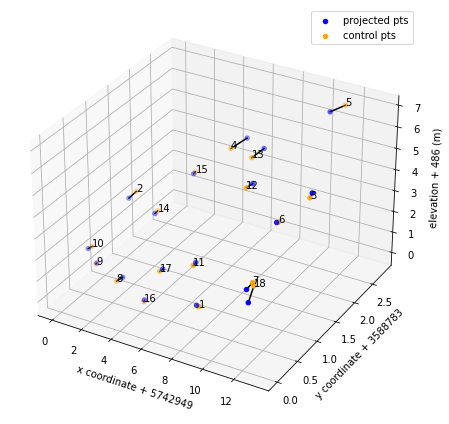

In [139]:
fig = pl.figure(figsize=(8, 6))
ax = fig.add_subplot(111, projection='3d')

#ax.set_aspect('equal')

leg_src = ax.scatter(srct_norm[:, 0], srct_norm[:, 1], srct_norm[:, 2], color='blue', label='projected pts')
leg_dst = ax.scatter(dst_norm[:, 0], dst_norm[:, 1], dst_norm[:, 2], color='orange', label='control pts')

for a, b in zip(srct_norm, dst_norm):
    ax.plot([a[0], b[0]], [a[1], b[1]], [a[2], b[2]], color='black')

for i, a in enumerate(dst_norm):
    ax.text(a[0], a[1], a[2], str(i+1), zorder=101)

ax.set_xlabel('x coordinate + %0.0f' % x0)
ax.set_ylabel('y coordinate + %0.0f' % y0)
ax.set_zlabel('elevation + %0.0f (m)' % z0)

ax.legend()

fig.tight_layout()

fn_out = os.path.join('fig', 'transform_error.pdf')

print('saving 3d fig with control points and projected location of control points as %s' % fn_out)

fig.savefig(fn_out)

**Fig. caption** *Comparison between the real coordinates of the control points and the location of the projected control points. Ideally the points should overlap. If not then there may be an issue with the control points. You can also try to make the optimization parameters xtol and ftol smaller or adjust the parameters for the initial guess of the transform to see if you can get a better fit*

## Save georeferenced pts to csv file

In [140]:
cols = ['id', 'source_x', 'source_y', 'target_x', 'target_y', 'projected_src_x', 'projected_src_y', 'transform_error']
index = np.arange(len(src))

df = pd.DataFrame(columns=cols, index=index)

for col in cp.columns:
    df[col] = cp[col]
    
#df['id'] = cp['id']
df['source_x'] = src[:, 0]
df['source_y'] = src[:, 1]
df['target_x'] = dst[:, 0]
df['target_y'] = dst[:, 1]
df['projected_src_x'] = srct[:, 0]
df['projected_src_y'] = srct[:, 1]
df['transform_error'] = transform_error

fnc = 'data/georeferencing_results_control_pts.csv'
print('saving csv file with result georeferencing control points as %s' % fnc)
df.to_csv(fnc)

df.head()

saving csv file with result georeferencing control points as data/georeferencing_results_control_pts.csv


,id,source_x,source_y,target_x,target_y,projected_src_x,projected_src_y,transform_error,ID,X,Y,ELEVATION,geometry
0,NaN,2026.600641,-2236.398594,5742957.030,3588783.368,5.742957e+06,3.588783e+06,0.108085,0,5742957.030,3588783.368,486.790,POINT (2026.601 -2236.399)
1,NaN,3745.403489,-1620.574986,5742950.239,3588784.310,5.742950e+06,3.588784e+06,0.190334,1,5742950.239,3588784.310,489.173,POINT (3745.403 -1620.575)
2,NaN,594.475281,-959.583088,5742961.948,3588784.179,5.742962e+06,3.588784e+06,0.115786,2,5742961.948,3588784.179,491.459,POINT (594.475 -959.583)
3,NaN,2465.584066,-1001.695166,5742955.311,3588784.789,5.742955e+06,3.588785e+06,0.376179,3,5742955.311,3588784.789,491.424,POINT (2465.584 -1001.695)
4,NaN,1303.852255,-612.002437,5742960.122,3588785.829,5.742960e+06,3.588786e+06,0.387682,4,5742960.122,3588785.829,492.735,POINT (1303.852 -612.002)


## Load shapefile that should be projected

In [141]:
shp = gp.read_file(shpfile)
shp.head()

,FID,geometry
0,0,"LINESTRING (518.362 -1139.601, 1464.451 -1400...."
1,1,"LINESTRING (1009.730 -1275.061, 987.286 -1395...."
2,2,"LINESTRING (623.263 -1319.963, 989.359 -1414.639)"
3,3,"LINESTRING (936.874 -1401.862, 944.354 -1494.726)"
4,4,"LINESTRING (539.561 -1413.767, 944.354 -1494.7..."


## Quality check on the shapefile

In [142]:
shp = shp.loc[shp.is_valid]

## Convert multipart geometries to single segments

In [143]:
shp = shp.explode()

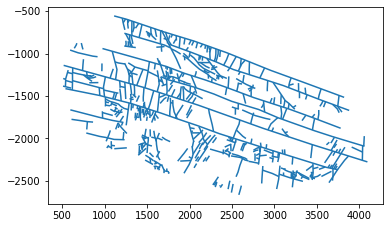

In [144]:
try:
    shp.plot()
    fig = pl.gcf()
    fig.savefig('fig/input_shapefile.pdf')
except Exception as e:
    print('something went wrong, could not generate figure of input shapefile')
    print(e)
    print('this is not a problem for executing the rest of this notebook')

## Project shapefile

In [145]:
gt = []

for g in shp.geometry:
    
    #if type(g) == shapely.geometry.multilinestring.MultiLineString:
        
    #    gti = []
    #    for gi in g:
            
    #        gc = np.array(gi.coords[:])

    #        gct = transform_func(params_opt, gc, order)

    ##        l = shapely.geometry.LineString(gct)

    #        gti.append(l)
    #    gt.append(shapely.geometry.MultiLineString(gti))

    #else:
    
    if normalize_coords is True:
        gc = np.array(g.coords[:])
        gc[:, 0] -= src_norms[0]
        gc[:, 1] -= src_norms[1]
        
        gct = transform_func(params_opt, gc, order)
        
        gct[:, 0] += dst_norms[0]
        gct[:, 1] += dst_norms[1]
        gct[:, 2] += dst_norms[2]
        
    else:
        gc = np.array(g.coords[:])
        gct = transform_func(params_opt, gc, order)

    l = shapely.geometry.LineString(gct)

    gt.append(l)

In [146]:
#shp['geometry_backup'] = shp.geometry
shp_georef = shp.copy()
shp_georef.geometry = gt

## Save georeferenced shapefile

In [147]:
fn_out = shpfile[:-4] + '_georef.shp'

print('saving georeferenced shapefile as\n\t%s' % fn_out)

shp_georef.to_file(fn_out)

fn_out = shpfile[:-4] + '_georef.geojson'

try:
    print('and saving the georeferenced fracture traces as geojson file\n\t%s' % fn_out)

    shp_georef.to_file(fn_out, driver='GeoJSON')
except Exception as e:
    print('warning, could not save the georeferenced fractures as GeoJSON file')
    print('error message: ', e)

saving georeferenced shapefile as
	data/fractures_georef.shp
and saving the georeferenced fracture traces as geojson file
	data/fractures_georef.geojson


## Show the georeferenced shapefile in xy coords (map view)

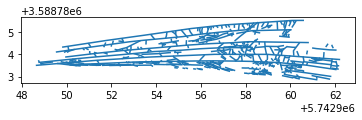

In [148]:
try:
    shp_georef.plot()
    fig = pl.gcf()
    fig.savefig('fig/georeferenced_shapefile.pdf')
except Exception as e:
    print('something went wrong, could not generate figure of georeferenced shapefile')
    print(e)
    print('this is not a problem for executing the rest of this notebook')

In [149]:
if normalize_coords is True:
    x0, y0, z0 = dst_norms

## Make a 3d figure of the georeferenced fracture network

saving 3d figure of georeferenced shapefile as fig/fractures_georef_3d_fig.pdf


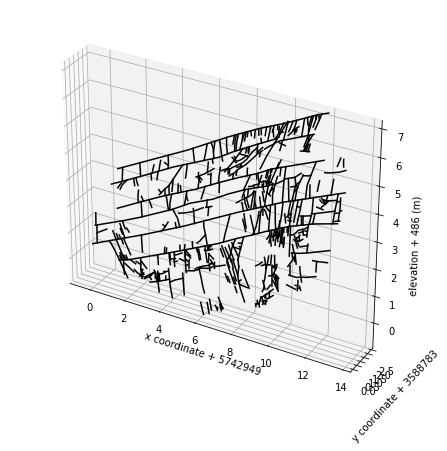

In [150]:
fig = pl.figure(figsize=(8, 6))
ax = fig.add_subplot(111, projection='3d')

for ls in shp_georef.geometry:
    #for ls in g:
    if type(ls) == shapely.geometry.multilinestring.MultiLineString:
        for lsi in ls:
            coords = np.array(lsi.coords[:])

            ax.plot(coords[:, 0] - x0, coords[:, 1] - y0, coords[:, 2] - z0, color='black')
    
    else:
        coords = np.array(ls.coords[:])

        ax.plot(coords[:, 0] - x0, coords[:, 1] - y0, coords[:, 2] - z0, color='black')

ax.set_xlabel('x coordinate + %0.0f' % x0)
ax.set_ylabel('y coordinate + %0.0f' % y0)
ax.set_zlabel('elevation + %0.0f (m)' % z0)

#set_axes_equal(ax)
try:
    ax.set_box_aspect((np.ptp(coords[:, 0] - x0), 
                       np.ptp(coords[:, 1] - y0), 
                       np.ptp(coords[:, 2] - z0)))
except Exception as e:
    print('warning, could not use ax.set_box_aspect to get equal aspect ratios for the 3D figure')
    print('upgrade to Matplotlib 3.3 or newer to enable this')
    print(e)
    
fig.tight_layout()

fn_out = os.path.join('fig', os.path.split(shpfile)[1][:-4] + '_georef_3d_fig.pdf')
print('saving 3d figure of georeferenced shapefile as %s' % fn_out)
fig.savefig(fn_out)

**Fig. caption** *The projected fracture network in 3D space* 

## Figure with 3d georeferenced shapefile projected to x, y and z plane

saving 2d figure of georeferenced shapefile as fig/fractures_georef_2d_fig.pdf


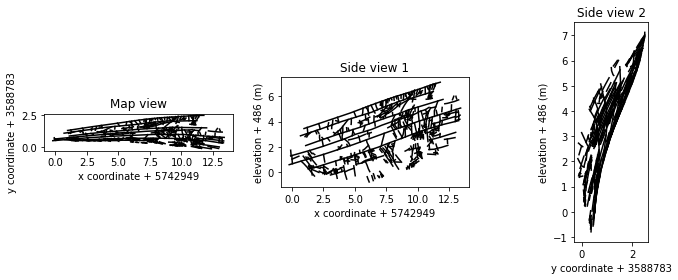

In [151]:
fig, axs = pl.subplots(1, 3, figsize=(10, 4))

for ax in axs:
    ax.set_aspect('equal')

for ls in shp_georef.geometry:
    #for ls in g:
    coords = np.array(ls.coords[:])

    axs[0].plot(coords[:, 0] - x0, coords[:, 1] - y0, color='black')
    axs[1].plot(coords[:, 0] - x0, coords[:, 2] - z0, color='black')
    axs[2].plot(coords[:, 1] - y0, coords[:, 2] - z0, color='black')

axs[0].set_xlabel('x coordinate + %0.0f' % x0)
axs[1].set_xlabel('x coordinate + %0.0f' % x0)
axs[0].set_ylabel('y coordinate + %0.0f' % y0)
axs[2].set_xlabel('y coordinate + %0.0f' % y0)
axs[1].set_ylabel('elevation + %0.0f (m)' % z0)
axs[2].set_ylabel('elevation + %0.0f (m)' % z0)

axs[0].set_title('Map view')
axs[1].set_title('Side view 1')
axs[2].set_title('Side view 2')


fig.tight_layout()

fn_out = os.path.join('fig', os.path.split(shpfile)[1][:-4] + '_georef_2d_fig.pdf')
print('saving 2d figure of georeferenced shapefile as %s' % fn_out)
fig.savefig(fn_out)

**Fig. caption** *The projected fracture network viewed from the top or the side xz or yz plane*

## Optional: Project the georefenced points to a plane

In [152]:
if project_shapefile is False:
    print('ending notebook here')
    exit()
else:
    print('proceeding with projection of georeferenced shapefile to a 2D plane')

proceeding with projection of georeferenced shapefile to a 2D plane


## Read file with points that define the plane to be projected to

In [153]:
if get_plane_pts_from_file is True:
    pp = gp.read_file(plane_pt_file) 
    
    print(pp)

    try:
        assert len(pp) >= 2
    except:
        msg = 'need at least two points to define a plane'
        raise IndexError(msg)

    # get coordinates of the plane
    px = pp[pp_x_col].values
    py = pp[pp_y_col].values
    pz = pp[pp_z_col].values

    if len(pp) == 2:
        print('found two points to define the plane. Assuming the plane is vertical and the third point is located above point 1')
        origin_id = np.argmin(px)
        px = np.append(px, px[origin_id])
        py = np.append(py, py[origin_id])
        xy_dist = np.sqrt((px[1] - px[0])**2 + (py[1] - py[0])**2)
        print('adding total hor distance of %0.2f to the vertical axis ' % xy_dist)
        pz = np.append(pz, pz[origin_id] + xy_dist)

    print('using the following points to define the plane:')
    print(list(zip(px, py, pz)))

    pp

## Alternative option: let the notebook define a plane for you

First option: a perfectly horizontal or vertical plane:

In [154]:
if get_plane_pts_from_file is False and (plane_orientation is 'vertical' \
        or plane_orientation is 'horizontal'):
    
    print('ignoring plane pts from file and basing on min and max coordinates georeferenced'
          'shapefile instead')
    
    # get min and max coords georeferenced shapefile
    coords_all = None
    
    for ls in shp_georef.geometry:
        #for ls in g:
        coords = np.array(ls.coords[:])
            
        if coords_all is None:
            coords_all = coords.copy()
            
        else:
            coords_all = np.vstack([coords_all, coords])
            
    xlims = [coords_all[:, 0].min(), coords_all[:, 0].max()]
    ylims = [coords_all[:, 1].min(), coords_all[:, 1].max()]
    zlims = [coords_all[:, 2].min(), coords_all[:, 2].max()]
    
    if plane_pt_functions is not None:
        
        xc = coords_all[:, 0]
        yc = coords_all[:, 1]
        zc = coords_all[:, 2]
        
        px = np.array([p(xc) for p in plane_pt_functions[0]])
        py = np.array([p(yc) for p in plane_pt_functions[1]])
        pz = np.array([p(zc) for p in plane_pt_functions[2]])
    
    elif plane_orientation is 'vertical':
        
        print('assuming a vertical projection plane')
        
        px = np.array([xlims[0], xlims[1], xlims[0]])
        py = np.array([ylims[0], ylims[1], ylims[0]])
        pz = np.array([zlims[0], zlims[0], zlims[1]])

    elif plane_orientation is 'horizontal':
        print('assuming a horizontal projection plane')
        #(xmin, ymin, zmin), (xmax, ymin, zmax), (xmin, ymax, zmin)
        
        px = np.array([xlims[0], xlims[1], xlims[0]])
        py = np.array([ylims[0], ylims[0], ylims[1]])
        pz = np.array([zlims[0], zlims[1], zlims[0]])    
       
        
    print('using the following points to define the plane:')
    print(list(zip(px, py, pz)))

ignoring plane pts from file and basing on min and max coordinates georeferencedshapefile instead
using the following points to define the plane:
[(5742948.620525362, 3588782.8580016573, 485.17204944351204), (5742962.223443415, 3588785.513711707, 485.17204944351204), (5742948.620525362, 3588782.8580016573, 493.08713727544693)]


## Resort plane pts if the first point is not the origin

In [155]:
if pp_origin_id != 0:
    print('resorting plane pts so that pt %i is the first one' % pp_origin_id)
    res = [i for i in [0, 1, 2] if i != pp_origin_id]
    new_ids_list = [pp_origin_id] + res
    new_ids = np.array(new_ids_list)
    pxi = px.copy()
    pyi = py.copy()
    pzi = pz.copy()
    px = pxi[new_ids]
    py = pyi[new_ids]
    pz = pzi[new_ids]

## Define origin of plane and relative coords

In [156]:
# define origin of the plane
if sort_plane_pts is True:
    px0 = px.min()
    py0 = py.min()
    pz0 = pz.min()
else:
    px0 = px[0]
    py0 = py[0]
    pz0 = pz[0]


if sort_plane_pts is True:
    # sort points to make sure the origin is the first pt
    pxi = px.copy()
    pyi = py.copy()
    pzi = pz.copy()
    origin_id = np.argmin(pxi)
    vert_id = np.argmax(pzi)
    ids = [origin_id, vert_id]
    res = [i for i in [0, 1, 2] if i not in ids][0] 
    new_ids = np.array([origin_id, res, vert_id])

    px = pxi[new_ids]
    py = pyi[new_ids]
    pz = pzi[new_ids]

pxr = px - px0
pyr = py - py0
pzr = pz - pz0

print('plane coordinates are relative to origin of')
print('x0 = %0.2f, y0=%0.2f, z0=%0.2f\n' % (px0, py0, pz0))

print('\nrelative coordinates plane:\n', list(zip(pxr, pyr, pzr)))

plane coordinates are relative to origin of
x0 = 5742948.62, y0=3588782.86, z0=485.17


relative coordinates plane:
 [(0.0, 0.0, 0.0), (13.602918053045869, 2.655710049904883, 0.0), (0.0, 0.0, 7.915087831934898)]


## Construct plane eq. with sympy

In [157]:
plane = sympy.Plane(sympy.Point3D(pxr[0], pyr[0], pzr[0]),
                    sympy.Point3D(pxr[1], pyr[1], pzr[1]),
                    sympy.Point3D(pxr[2], pyr[2], pzr[2]))

print('\nequation of the plane = %s' % str(plane.equation()))

a = plane.equation()

b = a.as_coeff_add()
plane_coeffs = [bi.as_coeff_Mul()[0].round(3) for bi in b[1]]
plane_coeffs.append(b[0].round(3))

if len(plane_coeffs) == 4:
    print('\nsimplified eq. of the plane = %0.3f z + %0.3fx + %0.3f y + %0.3f' 
          % (plane_coeffs[0], plane_coeffs[1], plane_coeffs[2], plane_coeffs[3]))
elif len(plane_coeffs) == 3:
    print('\nthe plane appears to be vertical or horizontal')
    print('\nsimplified eq. of the plane = %0.3fx + %0.3f y + %0.3f' 
          % (plane_coeffs[0], plane_coeffs[1], plane_coeffs[2]))


equation of the plane = 2627522287643667715146419039*x/125000000000000000000000000 - 10766829116047118366223551191*y/100000000000000000000000000

the plane appears to be vertical or horizontal

simplified eq. of the plane = -107.668x + 21.020 y + 0.000


## Select two vectors that lie in the plane

In [158]:
vect1_xy = [[pxr[0], pyr[0], pzr[0]], [pxr[1], pyr[1], pzr[1]]]
vect2_xy = [[pxr[0], pyr[0], pzr[0]], [pxr[2], pyr[2], pzr[2]]]

vect1_xy_array = np.array(vect1_xy)
vect2_xy_array = np.array(vect2_xy)

vect1 = shapely.geometry.LineString(vect1_xy)
vect2 = shapely.geometry.LineString(vect2_xy)

## Check if angle between vectors is 90 degrees:

In [159]:
# using Line() method 
l1 = sympy.Line((pxr[0], pyr[0], pzr[0]), (pxr[1], pyr[1], pzr[1])) 
l2 = sympy.Line((pxr[0], pyr[0], pzr[0]), (pxr[2], pyr[2], pzr[2])) 
  
# using angle_between() method 
rad = l1.angle_between(l2) 

a = rad.round(2)
angle_two_vectors = np.degrees(float(a))

print('the angle between the two vectors defining the plane is %0.3f degrees' % angle_two_vectors)

if angle_two_vectors != 90.0:
    print('warning the projection to a plane may fail if the angle of the two vectors is not equal to 90 degrees')
    print('please check the coordinates of the three points that define the two vectors')
    print('please also make sure these three points are in the right order, p1, p2, p3, with the vectors constructed as (p1, p2) and (p2, p3)')
    print('with the wrong order this would for instance yield (p2, p1) (p2, p3), which may result in two vectors that are not at a 90 degrees angle')

the angle between the two vectors defining the plane is 89.958 degrees
warning the projection to a plane may fail if the angle of the two vectors is not equal to 90 degrees
please check the coordinates of the three points that define the two vectors
please also make sure these three points are in the right order, p1, p2, p3, with the vectors constructed as (p1, p2) and (p2, p3)
with the wrong order this would for instance yield (p2, p1) (p2, p3), which may result in two vectors that are not at a 90 degrees angle


## Make a 3d figure of the georeferenced shapefile and the two vectors

saving 3d figure of georeferenced shapefile as fig/fractures_georef_3d_fig_v2.pdf


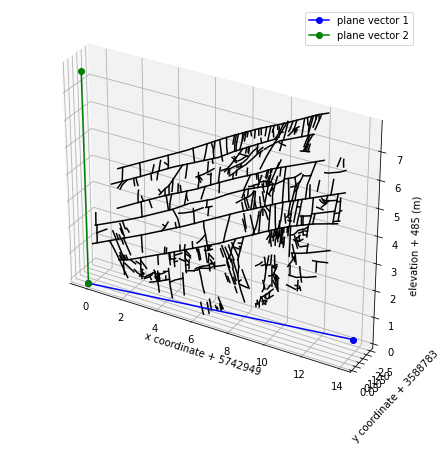

In [160]:
fig = pl.figure(figsize=(8, 6))
ax = fig.add_subplot(111, projection='3d')

for ls in shp_georef.geometry:
    #for ls in g:
    coords = np.array(ls.coords[:])

    ax.plot(coords[:, 0] - px0, coords[:, 1] - py0, coords[:, 2] - pz0, color='black')

ax.plot(vect1_xy_array[:, 0], vect1_xy_array[:, 1], vect1_xy_array[:, 2], 
        label='plane vector 1', color='blue', marker='o')
ax.plot(vect2_xy_array[:, 0], vect2_xy_array[:, 1], vect2_xy_array[:, 2], 
        label='plane vector 2', color='green', marker='o')

try:
    ax.set_box_aspect((np.ptp(coords[:, 0] - px0), 
                       np.ptp(coords[:, 1] - py0), 
                       np.ptp(coords[:, 2] - pz0)))
except Exception as e:
    print('warning, could not use ax.set_box_aspect to get equal aspect ratios for the 3D figure')
    print('upgrade to Matplotlib 3.3 or newer to enable this')
    print(e)
    
ax.set_xlabel('x coordinate + %0.0f' % px0)
ax.set_ylabel('y coordinate + %0.0f' % py0)
ax.set_zlabel('elevation + %0.0f (m)' % pz0)

ax.legend()

fig.tight_layout()

fn_out = os.path.join('fig', os.path.split(shpfile)[1][:-4] + '_georef_3d_fig_v2.pdf')
print('saving 3d figure of georeferenced shapefile as %s' % fn_out)
fig.savefig(fn_out)

**Fig. caption** *The projected fracture network and the two vectors that define the plane that the fractures will be projected onto*

## Projection onto a plane using shapely

projection on to a plane defined by two vectors. Using shapely to get the projected points and distance along each vector for the projected point

In [161]:
def ClosestPointOnLine(a, b, p):
    '''
    
    https://gamedev.stackexchange.com/questions/72528/how-can-i-project-a-3d-point-onto-a-3d-line
       
    ''' 
    ap = p - a
    ab = b - a
    
    result = a + np.dot(ap, ab) / np.dot(ab, ab) * ab
    
    return result


def projected_distance(a, b, p):
    
    # find the projected point
    projected_pt = ClosestPointOnLine(a, b, p)
    
    # find the distance between the projected pt and the origin (which is assumed to be a)
    distance = np.sqrt((projected_pt[0] - a[0])**2 + (projected_pt[1] - a[1])**2 + (projected_pt[2] - a[2])**2 )
    
    return distance


prs = np.array(list(zip(pxr, pyr, pzr)))

gpr = []

print('start projecting lines onto a plane defined by two vectors')
print('note: this may take a while....')

for i, g in enumerate(shp_georef.geometry):
    
    if int(i/100) == float(i/100):
        print('processing line segment %i of %i' % (i+1, len(shp_georef.geometry)))
    
    gc = np.array(g.coords[:])
    
    # convert the georeferenced coords to relative coords
    gc[:, 0] = gc[:, 0] - px0
    gc[:, 1] = gc[:, 1] - py0
    gc[:, 2] = gc[:, 2] - pz0
    
    #gcmp = shapely.geometry.MultiPoint(gc)
    
    gcp = []
    
    for gci in gc:
        
        #dx = vect1.project(gci)
        #dy = vect2.project(gci)
        dx = projected_distance(prs[0], prs[1], gci)
        dy = projected_distance(prs[0], prs[2], gci)
        
        gcp.append([dx, dy])
        
    #gcp_sympy = [plane.projection(sympy.Point3D(gci[0], gci[1], gci[2])) for gci in gc]
    
    #gcp = [[gi.x.round(2), gi.y.round(2), gi.z.round(2)] for gi in gcp_sympy]
    
    l = shapely.geometry.LineString(gcp)
    
    gpr.append(l)
    
print('done projecting')

start projecting lines onto a plane defined by two vectors
note: this may take a while....
processing line segment 1 of 468
processing line segment 101 of 468
processing line segment 201 of 468
processing line segment 301 of 468
processing line segment 401 of 468
done projecting


## Add new projected geometry to modified shapefile

In [162]:
shp_proj = shp_georef.copy()
shp_proj.geometry = gpr

## Save projected shapefile

In [163]:
fn_out = shpfile[:-4] + '_projected_to_plane.shp'

print('saving shapefile that was projected onto a plane as\n\t%s' % fn_out)

shp_proj.to_file(fn_out)

saving shapefile that was projected onto a plane as
	data/fractures_projected_to_plane.shp


## Save midpoints, length and orientation of projected fracture lines

In [164]:
columns = ['midpoint_x', 'midpoint_y', 'length', 'angle_with_horizontal']
index = shp_proj.index
df_midpoints = pd.DataFrame(columns=columns, index=index)

xms = np.zeros_like(index)
yms = np.zeros_like

for ix in shp_proj.index:
    x, y = shp_proj.loc[ix, 'geometry'].xy[:]
    
    xm = (x[0] + x[-1]) / 2.0
    ym = (y[0] + y[-1]) / 2.0
    
    dx = x[-1] - x[0]
    dy = y[-1] - y[0]
    
    length = np.sqrt(dx**2 + dy**2)
    
    df_midpoints.loc[ix, 'midpoint_x'] = xm
    df_midpoints.loc[ix, 'midpoint_y'] = ym
    df_midpoints.loc[ix, 'dx'] = dx
    df_midpoints.loc[ix, 'dy'] = dy
    df_midpoints.loc[ix, 'length'] = length
    
    angle = np.degrees(np.arctan2(dy, dx))
    
    if angle < 0:
        angle += 360.
    
    df_midpoints.loc[ix, 'angle_with_horizontal'] = angle

fnm = 'data/midpoints_lengths_angles.csv'
print('saving csv file with midpoints, angles and trace lengths as %s' % fnm)
df_midpoints.to_csv(fnm)  


saving csv file with midpoints, angles and trace lengths as data/midpoints_lengths_angles.csv


In [165]:
df_midpoints.head()

,,midpoint_x,midpoint_y,length,angle_with_horizontal,dx,dy
0,0,6.82419,3.61857,14.1351,198.548,-13.400891,-4.496462
1,0,11.8743,4.90649,0.866343,263.229,-0.102148,-0.860300
2,0,12.4951,5.01356,1.23922,197.587,-1.181302,-0.374426
3,0,12.0398,4.70596,0.350055,258.042,-0.072532,-0.342458
4,0,7.44208,2.95459,12.2843,198.099,-11.676473,-3.816123


## Make a figure with the original fracture dataset and the simplified fracture network

saving figure as fig/midpoints_and_lines.pdf


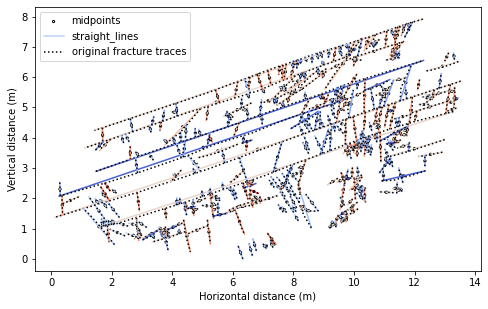

In [166]:
cmap = pl.get_cmap('coolwarm')
s = 5

colors = [cmap(i) for i in df_midpoints['angle_with_horizontal'].values / 360.]

fig, ax = pl.subplots(1, 1, figsize=(8, 6))

ax.set_aspect('equal')

legm = ax.scatter(df_midpoints['midpoint_x'], df_midpoints['midpoint_y'], 
           edgecolor='black', facecolor='None', s=s)

for ix, c in zip(df_midpoints.index, colors):
    xm = df_midpoints.loc[ix, 'midpoint_x']
    ym = df_midpoints.loc[ix, 'midpoint_y']
    
    angle = df_midpoints.loc[ix, 'angle_with_horizontal'] 
    
    length = df_midpoints.loc[ix, 'length']
    
    dxp = np.cos(np.radians(angle)) * length / 2.0
    dyp = np.sin(np.radians(angle)) * length / 2.0
    
    dxp2 = df_midpoints.loc[ix, 'dx']
    dyp2 = df_midpoints.loc[ix, 'dy']
    
    #cmap = plt.get_cmap('gnuplot')
    
    leg_segments, = ax.plot([xm-dxp, xm+dxp], [ym-dyp, ym+dyp], color=c)
    
    xp, yp = shp_proj.loc[ix].geometry.xy
    leg_orig, = ax.plot(xp, yp, ls=':', color='black')
    
ax.legend([legm, leg_segments, leg_orig], 
          ['midpoints', 'straight_lines', 'original fracture traces'])

ax.set_xlabel('Horizontal distance (m)')
ax.set_ylabel('Vertical distance (m)')

fnf = 'fig/midpoints_and_lines.pdf'
print('saving figure as %s' % fnf)
fig.savefig(fnf)

**Fig. caption** *The original fracture network and the network simplified as a series of midpoints and straight lines*

## Show new shapefile projected onto a plane

saving figure of shapefile projected to a plane as fig/fractures_projected_to_plane.pdf 


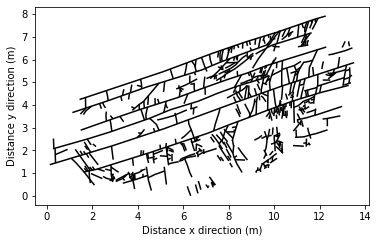

In [167]:
try:
    shp_proj.plot(color='black')

    fig = pl.gcf()
    ax = pl.gca()
    
    ax.set_xlabel('Distance x direction (m)')
    ax.set_ylabel('Distance y direction (m)')
    
    fn_out = os.path.join('fig', os.path.split(shpfile)[1][:-4] + '_projected_to_plane.pdf')
    print('saving figure of shapefile projected to a plane as %s ' % fn_out)
    fig.savefig(fn_out)

except Exception as e:
    print(e)

**Fig. caption** *The fracture network projected onto a 2D plane*

## Show original shapefile

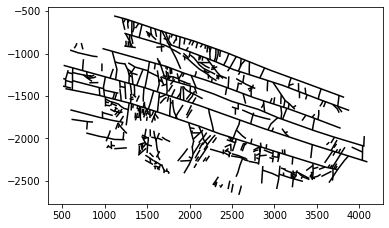

In [168]:
try:
    shp.plot(color='black')
except Exception as e:
    print(e)